# Тестовое задание

## Введение

### Общая информация

Мобильная игра зарабатывает на показе рекламы. Есть несколько форматов:
- int – полноэкранная реклама; 
- banner – горизонтальный баннер, висит внизу экрана пока юзер играет; 
- rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы. 

Информация о каждом показе отправляется в аналитику и содержит доход от показа, формат показанной рекламы, рекламную сеть от которой был показ и др.

eCPM – доход за 1000 показов рекламы.

### Бизнес задача

Провести исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров.

### Конкретные задачи

1. Для каждого формата рекламы:
    - построить распределение средних eCPM-ов юзеров.
    - построить распределение eCPM-ов по городам, версиям ОС.
    - построить распределение доходов по городам, версиям ОС.
2. Учесть статистическую значимость (отобразить, отфильтровать незначимое или хотя бы прокомментировать). Объяснить решение.
3. Описать наблюдения и вывод по исследованию.

### Дополнительные задачи

Исследовать:
- Какой процент доходов содержит информацию о городе юзера.
- Зависит ли eCPM от времени дня.

## Первичный анализ

Импортируем необходимые библиотеки.

In [2]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import json

### Выгрузка данных

Сохраним данные и посмотрим на первые 5 строк.

In [3]:
win_path = "C:/Users/Влад/Downloads/us events ad_revenue filtered 03.02-07.02.csv"
mac_path = '/Users/vkurichenko/Downloads/us events ad_revenue filtered 03.02-07.02.csv'

raw_data = pd.read_csv(win_path)

raw_data.head()

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


Согласно информации от заказчика, столбцы означают следующее:
- profile_id – id юзера
- event_json содержит данные о событии показа рекламы:
    - ad_type – формат рекламы (int, banner или rv)
    - placement – когда/где был показ рекламы в игре
    - view_index – номер показа конкретного формата рекламы для юзера (не поддерживается для баннеров)
    - revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)
    - ads_ltv – накапливающийся доход от рекламы, равен сумме всех revenue юзера
    - network_name – рекламная сеть, от которой был показ
- os_version – версия ПО устройства
- device_manufacturer – производитель устройства
- device_model – модель устройства
- device_type – тип устройства
- device_locale – язык устройства
- event_name – название события
- event_datetime – время события
- event_datetime – временной штамп события
- event_receive_datetime – время выгрузки события
- event_receive_timestamp – временной штамп выгрузки события
- connection_type – тип соединения
- operator_name – название оператора
- country_iso_code – код страны
- city – город

Посмотрим на размерность данных.

In [4]:
raw_data.shape

(860079, 16)

Итак, наш датасет содержит 860 тысяч строк и 16 колонок.

Посчитаем уникальное количество юзеров.

In [5]:
raw_data['profile_id'].nunique()

4226

В датасете присутствуют данные 4226 юзеров.

Одна из колонок, содержащая данные о событии показа рекламы имеет тип json. Разделим данные из нее на отдельные колонки.

In [6]:
data_json = pd.DataFrame(raw_data['event_json'].apply(json.loads).tolist())
data = raw_data.drop('event_json', axis=1).merge(data_json, left_index=True, right_index=True)

Посмотрим на размерность нового датасета.

In [7]:
data.shape

(860079, 32)

Соответственно, мы удалили исходную колонку и добавили 17 новых колонок в датасет. Теперь можно продолжить анализ.

### Пропущенные значения

Посчитаем пропущенные значения в данных.

In [8]:
data.isna().sum()

profile_id                     14
os_version                      0
device_manufacturer             0
device_model                    0
device_type                     0
device_locale                   0
event_name                      0
event_datetime                  0
event_timestamp                 0
event_receive_datetime          0
event_receive_timestamp         0
connection_type                 0
operator_name               18879
country_iso_code                0
city                       323708
ad_type                         0
placement                       0
view_index                      0
session_view_index              0
cur_ticks                       0
session_length                  0
revenue                         0
ads_ltv                         0
ecpm_sma                        0
normalized_ecpm_sma             0
value                           0
currency                        0
ad_country_code                 0
network_name                    0
ad_unit_id    

Видно, что есть пропуски в профиле пользователя. Однако, доля таких пропусков мала.

Пропусков в колонке с именем оператора уже больше, но он никак не фигурирует в нашем анализе, поэтому нам тоже они не особо важны.

Больше всего пропусков в городе пользователя. Несколько задач заказчика связаны непосредственно с анализом активности пользователей по городам. Избавляться от этих строк смысла нет, предлагается просто заменить пропущенные значения на 'Unknown'.

In [9]:
data.fillna('Unknown', inplace=True)

## Ответы на вопросы заказчика

### Распределение средних eCPM-ов юзеров

Посмотрим на колонки датасета чтобы понять, какие из них отвечают за значение eCPM.

In [10]:
data.columns

Index(['profile_id', 'os_version', 'device_manufacturer', 'device_model',
       'device_type', 'device_locale', 'event_name', 'event_datetime',
       'event_timestamp', 'event_receive_datetime', 'event_receive_timestamp',
       'connection_type', 'operator_name', 'country_iso_code', 'city',
       'ad_type', 'placement', 'view_index', 'session_view_index', 'cur_ticks',
       'session_length', 'revenue', 'ads_ltv', 'ecpm_sma',
       'normalized_ecpm_sma', 'value', 'currency', 'ad_country_code',
       'network_name', 'ad_unit_id', 'ad_network_placement', 'creativeId'],
      dtype='object')

В нашем датасете есть две колонки, содержащие ecpm: 'ecpm_sma' и 'normalized_ecpm_sma'.

Чтобы понять разницу между ними, опишем эти колонки методом 'describe'.

In [11]:
data[['ecpm_sma', 'normalized_ecpm_sma']].describe()

,ecpm_sma,normalized_ecpm_sma
count,860079.000000,860079.000000
mean,3.147110,3.227661
std,15.973978,16.433888
min,0.001014,0.001014
25%,0.139942,0.139942
50%,0.480991,0.480991
75%,0.772006,0.772006
max,908.876160,917.695618


Видно, что разницы между колонками практически нет, за исключением чуть большего среднего значения, стандратного отклонения и максимального значения, поэтому будем использовать первую колонку 'ecpm_sma'.

Посчитаем среднее значение 'ecpm' для юзера.

In [12]:
user_ecpm = data.groupby('profile_id').agg({'ecpm_sma':'mean'})

Определим валюту, представленную в датасете чтобы понимать, с чем мы работаем.

In [13]:
data['currency'].unique()

array(['USD'], dtype=object)

Наша валюта - доллар.

Построим гистограмму.

<AxesSubplot:xlabel='ecpm_sma', ylabel='Count'>

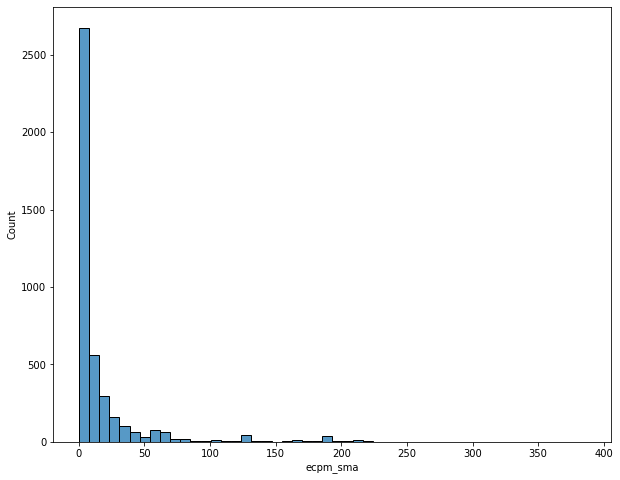

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=user_ecpm, x='ecpm_sma', ax=ax, bins=50)

Видно, что в основном заработок с юзера маленький, так как очень много значение сконцентрировано около 0.

Опишем данные методом describe.

In [15]:
user_ecpm.describe()

,ecpm_sma
count,4227.000000
mean,16.310835
std,33.298842
min,0.044203
25%,1.865125
50%,4.444360
75%,14.079033
max,386.488770


**Вывод:**
- Среднее значения дохода с пользователя составляет \\$16.3.
- При этом медианное значение дохода с юзеров - \\$4.4. То есть большое количество юзеров, заработок с которых очень большой (они смотрят много рекламы?)

### Распределение eCPM по городам и операционным системам

#### Распределение по ОС

Сначала посмотрим на столбец с операционными системами (ОС).

In [16]:
data[['os_version']].head()

,os_version
0,11
1,11
2,11
3,10
4,10


В данном случае ОС определяется просто цифрой.

Но что если в нашем датасете присутствуют девайсы, работающие как на iOS, так и на Android. В таком случае данные будут недостоверны.

Посмотрим на уникальных производителей в датасете.

In [17]:
data['device_manufacturer'].unique()

array(['Samsung', 'Google', 'TCL', 'LG', 'OnePlus', 'Motorola',
       'Teracube', 'Lenovo', 'T-Mobile', 'Verizon Wireless', 'Xiaomi',
       'Alcatel', 'Cricket', 'Blu', 'Kyocera', 'Maxwest', 'Nokia', 'FIH',
       'Dish', 'Schok', 'deejoy', 'AT&T', 'Zte', 'Redmi', 'Yulong',
       'Wiko', 'Huawei', 'Onn (Walmart)', 'AEEZO', 'Asus', 'JOYAR',
       'POCO', 'Ulefone', 'Razer'], dtype=object)

Отлично, в датасете нет устройств от Apple, поэтому можно предположить, что все девайсы работают на Android.

Посмотрим на количество уникальных значений ОС.

In [18]:
data['os_version'].nunique()

11

Посчитаем, как часто они встречаются, используя кумулятивную сумму долей каждой из ОС.

In [19]:
data['os_version'].value_counts(normalize=True).cumsum()

12       0.473895
11       0.716978
10       0.892394
9        0.969900
8.1.0    0.980654
8.0.0    0.989974
7.0      0.994691
7.1.2    0.996797
7.1.1    0.998357
5.0.2    0.999181
6.0.1    1.000000
Name: os_version, dtype: float64

97% всех девайсов работают на 4 версиях ОС.

Сгруппируем датасет по операционным системам и посчитаем среднее значение eCPM.

In [107]:
os_ecpm = data.groupby('os_version').agg({'ecpm_sma':'mean'}).sort_values(by='ecpm_sma', ascending=False)
os_ecpm

,ecpm_sma
os_version,
12,3.596887
11,3.230599
7.0,3.071182
10,2.489296
9,2.226091
8.0.0,1.707117
7.1.1,1.403852
8.1.0,1.110026
6.0.1,1.107547


Построим распределение, убрав при этом выбросы.

В случае с boxplot значения, выходящие за "усы", можно назвать выбросами, так как они соответствуют отклонениям более чем на 1.5 межквартильного размаха.

<AxesSubplot:xlabel='os_version', ylabel='ecpm_sma'>

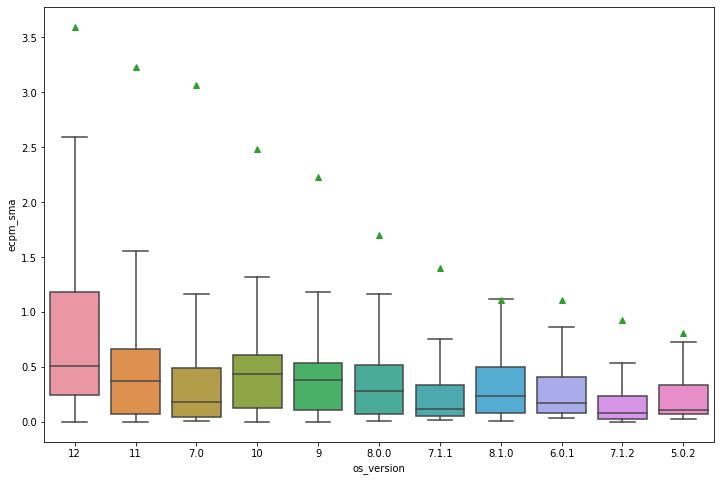

In [108]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=data, y='ecpm_sma', x='os_version', showfliers=False, showmeans=True, order=os_ecpm.index)

Можно сделать следующие выводы:
- Средние значения отклонены в сторону больших значений, что говорит о том, что много людей тратит на игры больше среднего и наше распределение смещено.
- Среднее значение eCPM падает для старых ОС. Но из этой зависимости выбивается Android 7.0. Может быть на это ОС все еще работает много старых девайсов, например, планшеты, которыми пользуются дети. Для того чтобы это проверить, необходимо дополнительно исследовать данные.
- В целом зависимость падения eCPM от ОС просто может быть связана с тем, что число пользователей в датасете выше для новых ОС.

#### Распределение по городам

Посчитаем количество уникальных городов.

In [67]:
data['city'].nunique()

921

Городов очень много, поэтому просто построить зависимости для каждого города не получится.

Посмотрим, как часто встречаются различные города, при этом не забыв убрать пользователей, которые город не указали.

In [94]:
data.query('city != "Unknown"')['city'].value_counts()[:10]

New York        17584
Minneapolis     12980
Houston         10137
Springfield     10135
Charlotte        9750
Chicago          8697
San Antonio      7912
Indianapolis     7126
Kansas City      7038
Gallatin         6573
Name: city, dtype: int64

Попробуем исследовать 10 самых часто встречающихся городов.

In [86]:
top_10_cities = data.query('city != "Unknown"')['city'].value_counts()[:10].index

In [97]:
city_ecpm = data.query('city in @top_10_cities').groupby('city').agg({'ecpm_sma':'mean'}).sort_values(by='ecpm_sma', ascending=False)
city_ecpm

,ecpm_sma
city,
Indianapolis,5.936076
Houston,3.870005
New York,2.973308
Kansas City,2.913684
Minneapolis,2.891356
Charlotte,2.847540
Chicago,1.824192
San Antonio,1.748343
Springfield,1.337842


<AxesSubplot:xlabel='city', ylabel='ecpm_sma'>

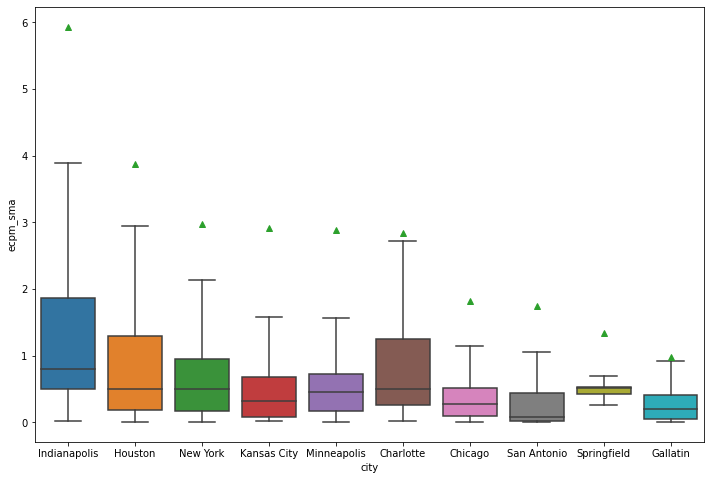

In [98]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=data.query('city in @top_5_cities'), y='ecpm_sma', x='city', showfliers=False, showmeans=True, order=city_ecpm.index)

Можно сделать выводы:

- В датасете действительно есть зависимость eCPM по городам. Например, среднее значение eCPM в Indianapolis почти в два раза больше, чем в Нью-Йорке, несмотря на то, что в датасете данных по Нью-Йорку почти в три раза больше.

**Общий вывод:**

- В данных присутствует зависимость среднего eCPM от ОС: для более новых ОС она выше (кроме Android 7.0).
- Также eCPM зависит от города.

### Распределение доходов по городам и операционным системам

Проведем такой же анализ, но уже непосредственно для значения доходов с рекламы на пользователя.

#### Распределение по ОС

In [137]:
os_revenue = data.groupby('os_version').agg({'revenue':'mean'}).sort_values(by='revenue', ascending=False)

<AxesSubplot:xlabel='os_version', ylabel='revenue'>

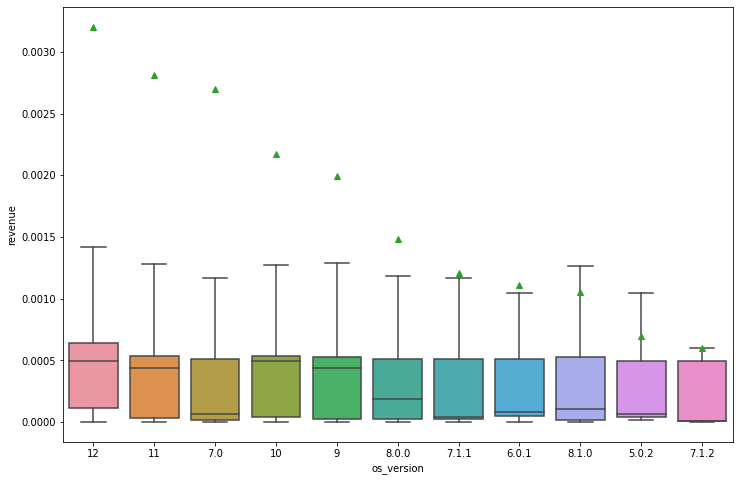

In [139]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=data, y='revenue', x='os_version', showfliers=False, showmeans=True, order=os_revenue.index)

Распределение похоже на распределение для eCPM, что не удивительно, ведь согласно заказчику, данные колонки связаны.

#### Распределение по городам

Также исследуем только 10 самых популярных городов.

In [143]:
city_rev = data.query('city in @top_10_cities').groupby('city').agg({'revenue':'mean'}).sort_values(by='revenue', ascending=False)
city_rev

,revenue
city,
Indianapolis,0.005147
Houston,0.003408
New York,0.002699
Kansas City,0.002655
Minneapolis,0.002638
Charlotte,0.002628
Chicago,0.001620
San Antonio,0.001398
Springfield,0.001226


<AxesSubplot:xlabel='city', ylabel='revenue'>

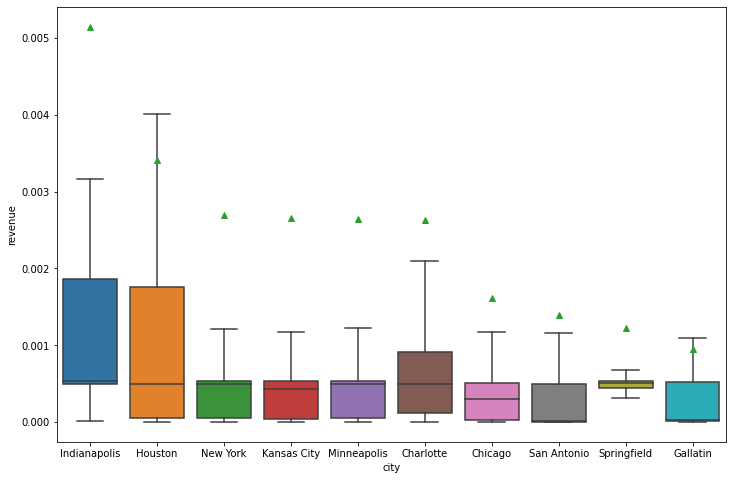

In [144]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(data=data.query('city in @top_5_cities'), y='revenue', x='city', showfliers=False, showmeans=True, order=city_rev.index)

Результаты также похожи на зависимость для eCPM.

**Общий вывод:**

- Зависимость распределения средних доходов от ОС и города похожа на такую же зависимость для среднего eCPM.

### Какой процент доходов содержит информацию о городе юзера

Посчитаем доходы отдельно для пользователей с указанным городом и без указанного города.

In [151]:
rev_known_city = data.query('city != "Unknown"')['revenue'].sum()
rev_unknown_city = data.query('city == "Unknown"')['revenue'].sum()

Теперь посчитаем необходимую долю доходов.

In [155]:
share = round(rev_known_city / (rev_known_city + rev_unknown_city) * 100, 1)
share

63.6

**Вывод:**

63.6% доходов от рекламы идут от пользователей с указанным городом.

### Зависит ли eCPM от времени дня

Для того, чтобы определить данную зависимость, переведем столбец с датой в формат datetime, а затем создадим новый столбец, в которые извлечем время показа рекламы.

In [164]:
data['event_datetime'] = pd.to_datetime(data['event_datetime'])
data['event_hour'] = data['event_datetime'].dt.hour

Теперь посчитаем средний eCPM для каждого часа.

In [179]:
ecpm_hour = data.groupby('event_hour').agg({'ecpm_sma':'mean'}).reset_index()

Построим график.

<AxesSubplot:xlabel='event_hour', ylabel='ecpm_sma'>

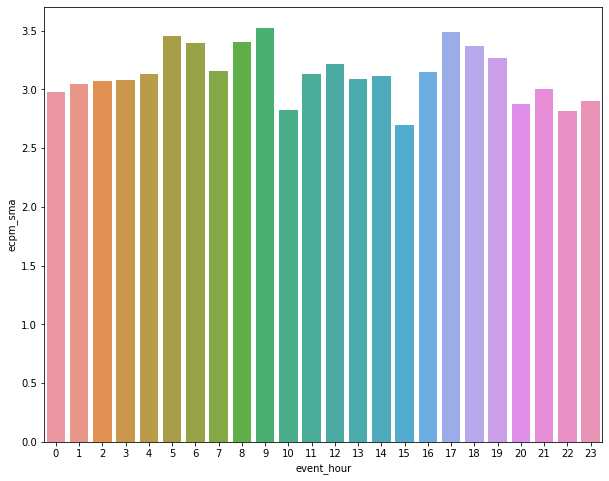

In [180]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=ecpm_hour, x='event_hour', y='ecpm_sma', ax=ax)

Видно, что средний eCPM не сильно зависит от времени дня. Есть небольшие пики на 9 утра и 5 вечера.

Посчитаем не среднее, а суммарный eCPM от времени дня.

<AxesSubplot:xlabel='event_hour', ylabel='ecpm_sma'>

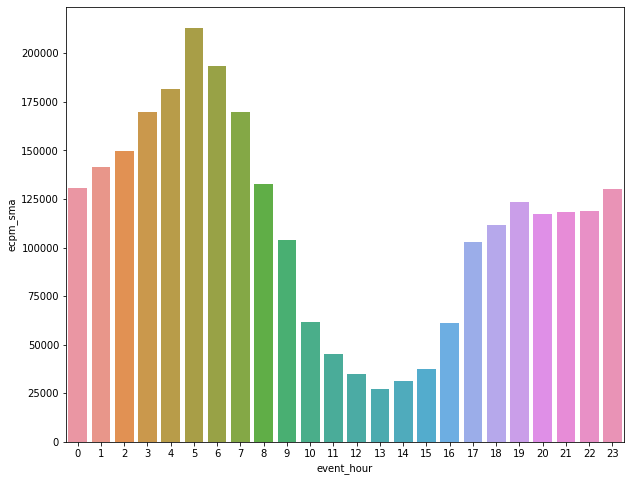

In [184]:
sum_ecpm_hour = data.groupby('event_hour').agg({'ecpm_sma':'sum'}).reset_index()
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=sum_ecpm_hour, x='event_hour', y='ecpm_sma', ax=ax)

На графике видно, что суммарный eCPM зависит от времени дня:
- Максимум суммарного eCPM приходится на 5 утра.
- Далее наблюдается сильное падение в "рабочее время" с 10 до 16 дня.
- Затем суммарный eCPM снова растет.

Такая зависимость может быть связана просто с большей активностью людей в данное время.
Построим такой же график, но не для суммы, а просто для количества информации в датасете по eCPM в разное время.

<AxesSubplot:xlabel='event_hour', ylabel='ecpm_sma'>

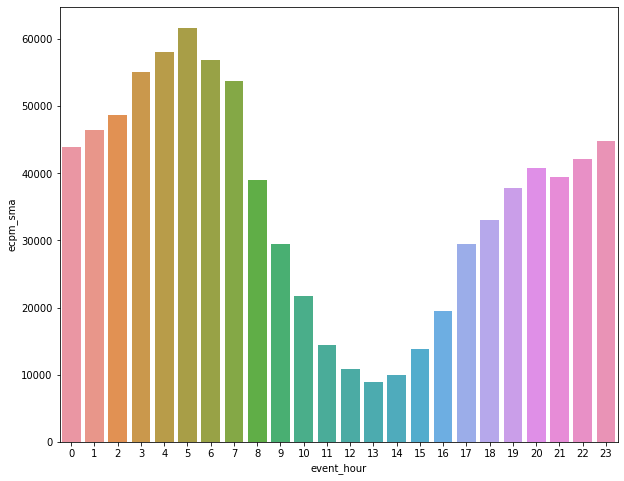

In [185]:
count_ecpm_hour = data.groupby('event_hour').agg({'ecpm_sma':'count'}).reset_index()
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=count_ecpm_hour, x='event_hour', y='ecpm_sma', ax=ax)

Зависимость такая же, что подтверждает сделанный вывод, что в рабочее время показы рекламы сокращаются.

**Вывод:**

- Среднее значение eCPM не сильно зависит от времени дня, то есть нет разницы, когда показывать рекламу.
- При этом суммарное значение eCPM зависит от времени дня, что определяется просто большим просмотром рекламы в разное время.

## Общий вывод

В данной работе было проведено исследование показов рекламы с целью понять на сколько отличается eCPM в зависимости от географии (города) юзера, версии ОС и других параметров. Было выявлено:

- Среднее значения eCPM с пользователя составляет \\$16.3. При этом медианное значение дохода с юзеров - \\$4.4.
- В данных присутствует зависимость среднего eCPM от ОС: для более новых ОС она выше (кроме Android 7.0). Также eCPM зависит от города.
- Зависимость распределения средних доходов от ОС и города похожа на такую же зависимость для среднего eCPM.
- 63.6% доходов от рекламы идут от пользователей с указанным городом.
- Среднее значение eCPM не сильно зависит от времени дня, то есть нет разницы, когда показывать рекламу. При этом суммарное значение eCPM зависит от времени дня, что определяется просто большим просмотром рекламы в разное время.

## Дальнейшие шаги

Для того, чтобы провести дополнительное исследование представленных данных, необходимы уточнения от заказчика.

Например, не совсем ясно, от чего именно зависит доход мобильной игры:
- Если от только от количества показов, то eCPM в данном случае не должны различаться между собой.
- Если же присутствует более сложная схема доходов, например, заказчик рекламы затем рассчитывает, какое количество пользователей воспользовалось его предложением именно после перехода из этой игры, то необходимо исследование зависимости eCPM, например, от конкретной рекламы.